<a href="https://colab.research.google.com/github/trangd02-1762018/trangd02-1762018.github.io/blob/master/Copy_of_3_Sentiment_Analysis_Spring_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
%matplotlib inline

# sklearn specific imports 
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec


### Part 0: Load and Clean Data





In [ ]:
products = pd.read_csv('products.csv')
products = products.iloc[0:5000] # For the sake of computation, we will only look at 5000 reviews
print('Number of reviews:', len(products))
print('Dataframe Columns', products.columns)
# Let's look at a specific product
print('Name:', products.iloc[0]['name'])
print('Review:', products.iloc[0]['review'])
print('Rating:', products.iloc[0]['rating'])

# REMOVE products with review equal to 3
products = products[products['rating'] != 3]

def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review'] = products['review'].apply(remove_punctuation)
len(products)
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

Number of reviews: 5000
Dataframe Columns Index(['name', 'review', 'rating'], dtype='object')
Name: Stop Pacifier Sucking without tears with Thumbuddy To Love's Binky Fairy Puppet and Adorable Book
Review: All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love's Binky Fairy Puppet.  It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!!  You will save them soo many headaches.Thanks for this book!  You all rock!!
Rating: 5


,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried nonstop when I tried...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,I only purchased a secondyear calendar for my ...,2,-1
3,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago S...,5,1
4,"Lamaze Peekaboo, I Love You",One of babys first and favorite books and it i...,4,1


Train/test split and lockbox our test set
---



In [ ]:
products_train, products_test = train_test_split(products, test_size = 0.2, random_state = 1)

In [ ]:
#find the majority class (positive or negative) in the training set
pos = products_train[products_train['sentiment']==1]
neg = products_train[products_train['sentiment']==-1]
print("Positive: "+str(len(pos)))
print("Negative: "+str(len(neg)))
#The most common is Negative (-1)
#predict how well this will do on the test set
print(len(products_test[products_test["sentiment"]==-1])/len(products_test))

Positive: 1691
Negative: 2309
0.586


### Featurizing sentences

In [ ]:
count_vectorizer = CountVectorizer(lowercase=True, token_pattern=u"(?u)\\b\\w+\\b", stop_words='english')
X_train = count_vectorizer.fit_transform(products_train['review'])
y_train = products_train['sentiment']

words = count_vectorizer.get_feature_names()
print(words) # show the vocabulary that it builds from the reviews in the training set

# The two numbers printed out should match
print('vocab in count_vectorizer:', len(count_vectorizer.get_feature_names()), 'dimension of X', X_train.shape[1])

# We "trained" our count-vectorizer on the train set, now we run it on the test-set
X_test = count_vectorizer.transform(products_test['review'])
y_test = products_test['sentiment']

# Finally we build a tokenizer
tokenizer = count_vectorizer.build_analyzer() # We will use this later to tokenize our sentences

['0', '001', '01', '010204', '016sc01', '02072', '03', '04', '05', '06', '07', '075long', '08', '0804', '080710', '1', '10', '100', '1000', '100feet', '100i', '100ile', '100lbs', '100oz', '100s', '100th', '1011', '1014', '1015', '1023', '103', '1032', '103in', '105', '107lbs', '10k', '10lbs', '10lbs35lbs', '10mins', '10month', '10monthold', '10mths', '10oz', '10th', '11', '110', '112', '1125', '11995', '12', '120', '1200', '122703', '123', '1230', '123or', '125', '129', '1295', '1299', '12lb', '12monthold', '12oz', '12quotx24quot', '12th', '12that', '12x12', '13', '130', '1300', '13000', '130lbs', '133', '1359', '13gallon', '13lb', '13mo', '13month', '13monthold', '13th', '13that', '14', '1400', '1413', '141600', '145', '149', '1499', '14month', '14months', '15', '150', '1500', '1520', '1590', '15hrs', '15lb', '15lbs', '15month', '15mos', '16', '160', '165', '1699', '16month', '16months', '16x20', '17', '17inches', '17lbs', '17th', '17wks', '18', '1800', '18002686237', '1800diapers', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Train a logisitic regression model on the training set
sentiment_model = LogisticRegression(C=1)
sentiment_model.fit(X_train,y_train)

LogisticRegression(C=1)

Now we can use this model to make predictions. Use the model to find the predicted probabilities on a small subset of 3 points

In [ ]:
sample_test_data = X_test[1:11]
#use sentiment_model.predict_proba to get the predicted probabilities for these three examples
sentiment_model.predict_proba(sample_test_data)

array([[9.87183651e-01, 1.28163488e-02],
       [9.65456091e-01, 3.45439088e-02],
       [1.97189486e-01, 8.02810514e-01],
       [6.19836617e-04, 9.99380163e-01],
       [6.88248772e-01, 3.11751228e-01],
       [9.84068040e-01, 1.59319596e-02],
       [9.44270372e-01, 5.57296280e-02],
       [9.84759031e-01, 1.52409692e-02],
       [1.59305465e-01, 8.40694535e-01],
       [1.33366270e-03, 9.98666337e-01]])

In [ ]:
print(list(zip(words[1500:1520],sentiment_model.coef_[0,1500:1520])))

[('bathsi', -0.01879155131824353), ('baththe', 0.08114320284273861), ('bathtime', 0.09278254596757186), ('bathtimeand', -9.306374851671083e-05), ('bathtub', 0.47138829902137325), ('bathtubs', 0.2064865194534527), ('bathtubthe', -0.01267560630342603), ('bathtubthis', 0.05923402067033649), ('batiste', -0.040196954524154366), ('batted', 0.040471003004865655), ('battered', 0.015435312117469827), ('batteries', -0.7777566448313847), ('batteries3', -0.0007042062401662621), ('batteriesnow', -0.008350762108904609), ('battery', -0.6723368116415548), ('batterytake', -9.64150543914826e-06), ('batting', -0.012246095624738626), ('battle', -0.01637143240193671), ('bauer', -0.3547659435746761), ('baught', -0.056010711730864825)]


In [ ]:
#get 5 largest indices
coef=sentiment_model.coef_[0]
words=count_vectorizer.get_feature_names()
coef_order= np.argsort(coef)
words=np.array(words)
print(words[coef_order[-5:]])

['best' 'easy' 'loves' 'highly' 'love']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Part 2: Assessing the Bag of words model


In [ ]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])
    
    sns.heatmap(data, annot=True, cmap='YlGnBu',
                xticklabels=['Actual Pos.', 'Actual Neg.'], 
                yticklabels=['Pred. Pos.', 'Pred. Neg.'])

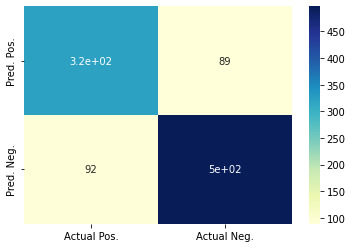

In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
i = 0
pred = sentiment_model.predict(X_test)

# Compute the number of true positives, false positives, true negatives, false negatives
# on the test set. 
tp = np.sum(np.logical_and(pred == 1, y_test == 1))
tn = np.sum(np.logical_and(pred == -1, y_test == -1))
fp = np.sum(np.logical_and(pred == 1, y_test == -1))
fn = np.sum(np.logical_and(pred == -1, y_test == 1))

plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)


In [ ]:
#use sklearns accuracy_score function to compute the accuracy of the model on the test set
accurary = accuracy_score(y_test,pred)
print(accurary)

0.819


### Part 3: Build a Classifier using word2vec features


In [ ]:
import gensim.downloader as api
model = api.load("glove-twitter-100")


[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
# word2vec model
def get_average_word2vec(sentence, tokenizer, word2vec):
    tokens = tokenizer(sentence)
    v  =0
    total = 0
    for word in tokens:
        if word in word2vec.vocab:
            total += 1
            vec = word2vec.word_vec(word) # TODO: get the word_vec from the word2vec model as in Problem 4
            v += vec/np.linalg.norm(vec) 
    if total>0:
        return v/total
    return np.zeros(300)

# The tokenizer we use was trained above
X_train = np.array([get_average_word2vec(sentence, tokenizer, model) for sentence in products_train['review']])
X_test = np.array([get_average_word2vec(sentence, tokenizer, model) for sentence in products_test['review']])

#Train a logistic model 
sentiment_model_w2v = LogisticRegression()
sentiment_model_w2v.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# use sklearns accuracy_score function to compute the accuracy of the model on the test set
model_acc = accuracy_score(y_test,sentiment_model_w2v.predict(X_test))
print(model_acc)